# Optimizacija hiperparametrov rf

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
import __C_konstante as kon
%matplotlib inline

In [2]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load your dataset
df = pd.read_csv(f'{kon.path_files}/molekulski_prstni_odtisi/df_topological-torsion.csv')
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=kon.random_seed, stratify=y)

# Define cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=kon.random_seed)

# Define the Optuna optimization function
def objective(trial):
    # Define hyperparameters for RandomForest
    n_estimators = trial.suggest_int('n_estimators', 10, 200)  # Tuning the number of trees
    max_depth = trial.suggest_int('max_depth', 1, 20)  # Tuning max depth
    min_samples_split = trial.suggest_int('min_samples_split', 5, 10)  # Tuning min samples for split
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Tuning min samples for leaf node
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # Tuning max features
    
    # Define feature selection (SelectKBest)
    k_best = trial.suggest_int('k_best', 5, 300)  # Tuning the number of features to select X_train.shape[1]
    
    # Create the pipeline with VarianceThreshold and SelectKBest
    model = Pipeline([
        ('variance_threshold', VarianceThreshold()),  # Apply VarianceThreshold to remove low-variance features
        ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),  # Apply SelectKBest with chi2 scoring function
        ('rf', RandomForestClassifier(n_estimators=n_estimators, 
                                      max_depth=max_depth, 
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,  # Include min_samples_leaf
                                      max_features=max_features,
                                      n_jobs=-1,
                                      random_state=kon.random_seed))
    ])
    
    # Cross-validation: Optimize based on mean accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(cv_scores)  # Return the mean of the cross-validation scores

# Create the Optuna study and optimize it
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Number of trials to run (can adjust this)

# Output the best trial results
print('Best trial:')
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

[I 2024-12-30 17:32:05,828] A new study created in memory with name: no-name-f583751b-d856-47a9-b77a-e536dcf17dfe
[I 2024-12-30 17:32:07,532] Trial 0 finished with value: 0.85783334016851 and parameters: {'n_estimators': 116, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'k_best': 46}. Best is trial 0 with value: 0.85783334016851.
[I 2024-12-30 17:32:08,819] Trial 1 finished with value: 0.8599485994723244 and parameters: {'n_estimators': 63, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': None, 'k_best': 281}. Best is trial 1 with value: 0.8599485994723244.
[I 2024-12-30 17:32:09,565] Trial 2 finished with value: 0.8539117715410589 and parameters: {'n_estimators': 41, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'k_best': 203}. Best is trial 1 with value: 0.8599485994723244.
[I 2024-12-30 17:32:10,936] Trial 3 finished with value: 0.8505866859874324 and parameters: {'n_est

Best trial:
  Value: 0.8804705335538816
  Params: {'n_estimators': 104, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'k_best': 277}


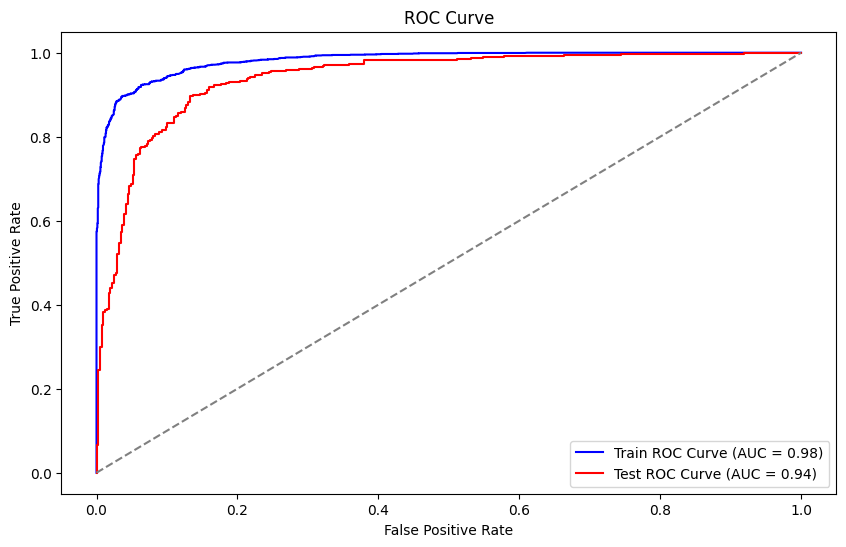

In [3]:
# Extract the best hyperparameters
best_params = best_trial.params
n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']
min_samples_split = best_params['min_samples_split']
max_features = best_params['max_features']
k_best = best_params['k_best']

# Create the final pipeline with the best parameters
final_model = Pipeline([
    ('variance_threshold', VarianceThreshold()), 
    ('select_k_best', SelectKBest(score_func=chi2, k=k_best)),
    ('rf', RandomForestClassifier(n_estimators=n_estimators, 
                                  max_depth=max_depth, 
                                  min_samples_split=min_samples_split,
                                  max_features=max_features,
                                  n_jobs=-1,
                                  random_state=42))
])

# Fit the model on the full training data
final_model.fit(X_train, y_train)

# Predictions for train data
y_train_pred = final_model.predict(X_train)
y_train_prob = final_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

# Predictions for test data
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Calculate accuracy and AUC for train and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_prob)
test_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, color='blue', label=f'Train ROC Curve (AUC = {train_auc:.2f})')
plt.plot(fpr_test, tpr_test, color='red', label=f'Test ROC Curve (AUC = {test_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Train Accuracy: 0.9279
Test Accuracy: 0.8709
Train AUC: 0.9821
Test AUC: 0.9404


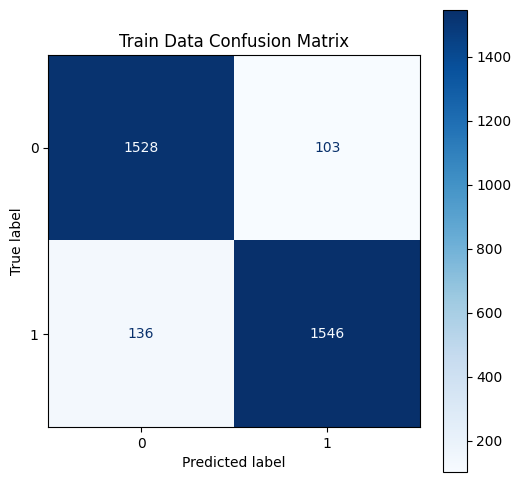

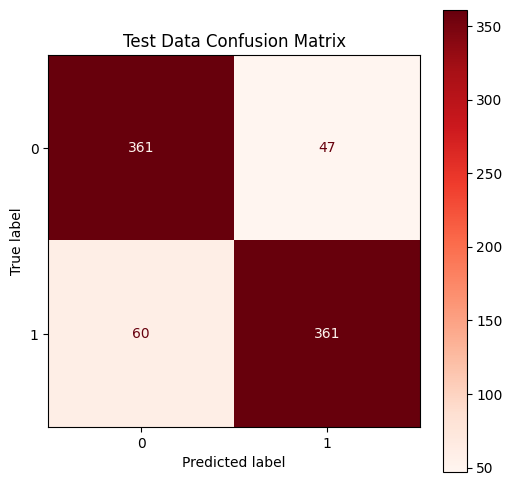

In [4]:
# Confusion Matrix for Train and Test
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

# Print accuracy and AUC scores
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


# Display Confusion Matrix for Train data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=train_cm).plot(cmap='Blues', ax=ax)
ax.set_title('Train Data Confusion Matrix')
plt.show()

# Display Confusion Matrix for Test data
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=test_cm).plot(cmap='Reds', ax=ax)
ax.set_title('Test Data Confusion Matrix')
plt.show()